In [5]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
#import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
#from curlyBrace import curlyBrace
%matplotlib widget

In [6]:
#scipy.stats uses numpy.random seed
np.random.seed(seed=0)

In [7]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

In [8]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [9]:
class GaussianMixture:
    def __init__(self, locations, scales, probas):
        # locations - vector of location parameters
        # scales - vector of scale parameters
        # probas - vector of mixture coefficients
        if not (len(locations) == len(scales) and len(scales) == len(probas)):
            raise ValueError("Wrong number of components for Gaussian Mixture")
        self.locations = locations
        self.scales = scales
        self.n_gauss = len(locations)
        self.gauss_rv = [st.norm(loc, scale) for loc, scale in zip(locations, scales)]
        probas_sum = np.sum(probas)
        probas = [proba / probas_sum for proba in probas]
        self.probas = probas

    # draw sample from GaussianMixture model
    def rvs(self, N):
        inds = st.rv_discrete(values=(range(self.n_gauss), self.probas)).rvs(size=N)
        X = [self.gauss_rv[ind].rvs(size=1)[0] for ind in inds]
        return X

    def cdf(self, x):
        cdf = 0
        for p, rv in zip(self.probas, self.gauss_rv):
            cdf += p * rv.cdf(x)
        return cdf

    def pdf(self, x):
        pdf = 0
        for p, rv in zip(self.probas, self.gauss_rv):
            pdf += p * rv.pdf(x)
        return pdf

In [10]:
lls = GaussianMixture([-1,0,1],[0.1,0.1,0.1],[0.4,0.4,0.2])
lsl = GaussianMixture([-1,0,1],[0.1,0.1,0.1],[0.4,0.2,0.4])

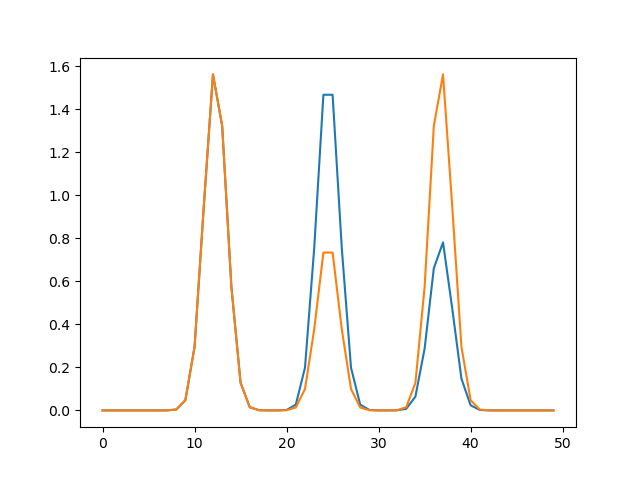

In [11]:
f,ax=plt.subplots()
x = np.linspace(-2,2)
ax.plot(lls.pdf(x))
ax.plot(lsl.pdf(x))
plt.show()

In [12]:
n=1000
n_loops = 1000
d = 1
steps = 1001
maxfilt = 1000

In [13]:
samples_lls = [n*np.array([[s] for s in lls.rvs(n)]) for i in range(0,n_loops)]
samples_lsl = [n*np.array([[s] for s in lsl.rvs(n)]) for i in range(0,n_loops)]

KeyboardInterrupt: 

In [10]:
ecc_lls = get_ecc(samples_lls, steps, maxfilt)
ecc_lsl = get_ecc(samples_lsl, steps, maxfilt)

In [11]:
avg_ecc_lls = np.mean(ecc_lls, axis = 0)
avg_ecc_lsl = np.mean(ecc_lsl, axis = 0)

In [12]:
f,ax = plt.subplots()
x = np.linspace(0,maxfilt,steps)
ax.plot(x, avg_ecc_lls)
ax.plot(x, avg_ecc_lsl)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
np.max(np.abs(avg_ecc_lls-avg_ecc_lsl))

0.5560000000000116